<a href="https://colab.research.google.com/github/xydeep21/ABTesting/blob/main/ABTesting_EDA_YUANXU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**`Import packages and load the data `**


In [25]:

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns",None)
%matplotlib inline
from google.colab import files
import io
import warnings
warnings.filterwarnings('ignore')


In [34]:
uploaded = files.upload()
row_data = pd.read_csv(io.BytesIO(uploaded["Python_project_eda.csv"]))


Saving Python_project_eda.csv to Python_project_eda (1).csv


In [35]:
row_data.head()

,buyer_week_before,clicked_buy_before,country,existing_buyer,initial_fop_set,made_purchase_before,saw_cart_before,spend_usd_next_14_days,user_added_credit_card,user_added_dcb,user_added_fop,user_added_gift_card,user_added_paypal,user_id,visit_before
0,0,0.0,IN,0,False,0.0,1.0,NaN,NaN,NaN,0,NaN,NaN,18321316048201303366,1
1,0,0.0,IN,0,False,0.0,1.0,NaN,NaN,NaN,0,NaN,NaN,13705367724816913241,1
2,0,NaN,IN,0,False,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,6605724765451655114,0
3,0,1.0,CA,1,True,1.0,1.0,7.398815,1.0,0.0,1,0.0,0.0,2340067911948261502,1
4,7,1.0,PL,1,True,1.0,1.0,NaN,0.0,1.0,1,0.0,0.0,11891045596810635427,1


In [36]:
row_data.shape

(566699, 15)

**Data** **Cleansing** 





In [37]:
## Remove duplicate values
row_data = row_data.drop_duplicates()

In [43]:
## Checking the missing value
len(row_data) - row_data.count()

buyer_week_before              0
clicked_buy_before         71059
country                    12524
existing_buyer                 0
initial_fop_set                0
made_purchase_before       71059
saw_cart_before            71059
spend_usd_next_14_days    477667
user_added_credit_card         0
user_added_dcb                 0
user_added_fop                 0
user_added_gift_card           0
user_added_paypal              0
user_id                        0
visit_before                   0
dtype: int64

In [42]:
## Deal with the data related to payment method. They have same missing values
## They can be treat as Boolean values, if add payment method then 1 else 0
row_data["user_added_credit_card"].fillna(0,inplace=True)
row_data["user_added_dcb"].fillna(0,inplace=True)
row_data["user_added_gift_card"].fillna(0,inplace=True)
row_data["user_added_paypal"].fillna(0,inplace=True)

In [45]:
## The field named "spend_usd_next_14_days" can also treated as Boolean value indicates spend or not
row_data["spend_usd_next_14_days"].fillna(0,inplace=True)


In [52]:
## Drop all other missing values and check the data again
df = row_data.dropna()
print(len(df)-df.count() ,len(df)/len(row_data))

buyer_week_before         0
clicked_buy_before        0
country                   0
existing_buyer            0
initial_fop_set           0
made_purchase_before      0
saw_cart_before           0
spend_usd_next_14_days    0
user_added_credit_card    0
user_added_dcb            0
user_added_fop            0
user_added_gift_card      0
user_added_paypal         0
user_id                   0
visit_before              0
dtype: int64 0.8546988789463189


**Exploration**

In [53]:
## The target variable is "spend_usd_next_14_days"
spend_usd_next_14_days = df.spend_usd_next_14_days
spend_usd_next_14_days.describe()

count    484357.000000
mean         12.066857
std          94.333699
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       22519.570000
Name: spend_usd_next_14_days, dtype: float64

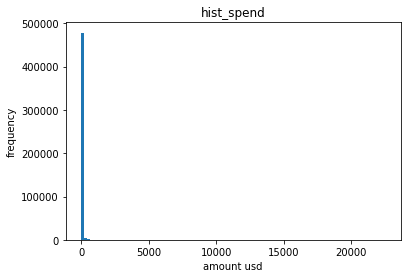

In [57]:
plt.hist(spend_usd_next_14_days, bins = 100)
plt.xlabel("amount usd")
plt.ylabel("frequency")
plt.title("hist_spend")
plt.show()

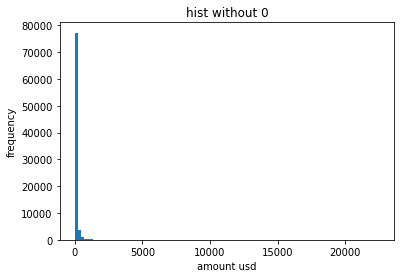

In [58]:
## Draw a histgram without 0 values
plt.hist(spend_usd_next_14_days[spend_usd_next_14_days != 0], bins = 100)
plt.xlabel("amount usd")
plt.ylabel("frequency")
plt.title("hist without 0")
plt.show()

In [89]:
## Consumption distribution
sum_total = df["spend_usd_next_14_days"].sum()
sum_less_100 = df[df["spend_usd_next_14_days"]>100].sum()
percent_less_100 = sum_less_100.spend_usd_next_14_days/sum_total
print(f"total usd spend is {sum_total}, The total consumption amount below 100 is {sum_less_100.spend_usd_next_14_days} \nThe percentage is{percent_less_100}")


total usd spend is 5844666.432973, The total consumption amount below 100 is 4333889.050864 
The percentage is0.7415117869540221


In [90]:
## Customer number distribution
n = len(spend_usd_next_14_days) + 0.0
print(f"users who spend samller than 100 usd is {len(spend_usd_next_14_days[spend_usd_next_14_days < 100]) / n}")

users who spend samller than 100 usd is 0.9724273624619857


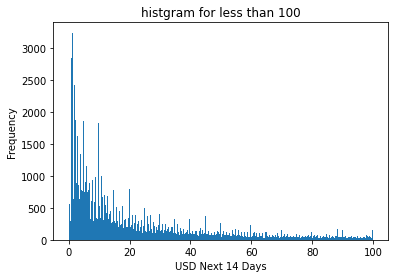

In [80]:
plt.hist(spend_usd_next_14_days[(spend_usd_next_14_days <= 100) & (spend_usd_next_14_days != 0)], bins = 300)
plt.xlabel("USD Next 14 Days")
plt.ylabel("Frequency")
plt.title("histgram for less than 100")
plt.show()
##From the point of view of spending amount and number of consumers, our main customers are among those who spend less than 100 usd 

**Build up purchase pipeline to find key metrics**

In [84]:
##Purchase process analysis
n_total = len(df)
n_visited = df["visit_before"].sum()
n_saw = df["saw_cart_before"].sum()
n_clicked = df["clicked_buy_before"].sum()
n_purchased = df["made_purchase_before"].sum()
process_df = pd.DataFrame(columns=["action", "num", "cr_stage"])
process_df["action"] = ["visited", "saw", "clicked", "purchased"]
process_df["num"] = [n_visited, n_saw, n_clicked, n_purchased]
process_df["cr_stage"] = np.array([n_visited, n_saw, n_clicked, n_purchased]) / n_total
print(process_df)

      action       num  cr_stage
0    visited  484357.0  1.000000
1        saw  451933.0  0.933058
2    clicked  124233.0  0.256491
3  purchased  101911.0  0.210405


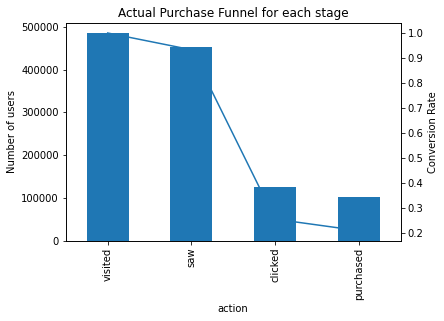

In [85]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
funnel_df.plot.bar("action","num", ax = ax1, legend=False)
funnel_df.plot("action","cr_stage", ax = ax2, legend=False)
ax1.set_ylabel("Number of users")
ax2.set_ylabel("Conversion Rate")
ax1.set_title("Actual Purchase Funnel for each stage")
plt.show()

In [87]:
## Taking care about the drop between clicked and purchased
failed_to_purchase = 1- (n_purchased/n_clicked)
failed_to_purchase

0.17967850732092117

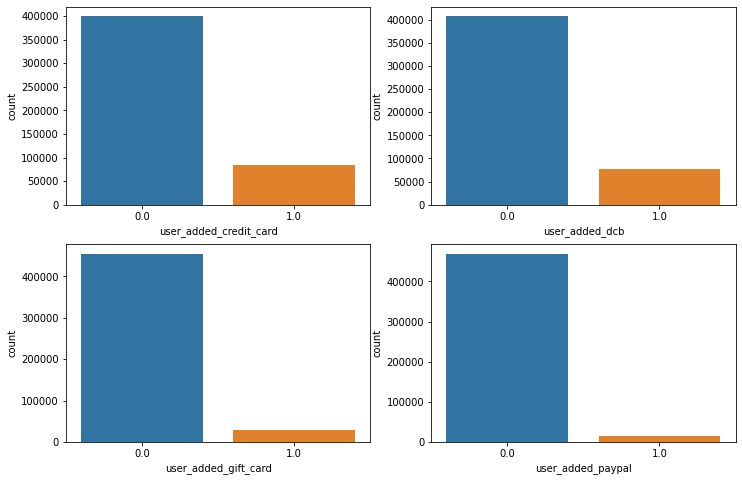

In [91]:
##Deep into payment method which may be highly related to this purchase failure 
target_features = ["user_added_credit_card", "user_added_dcb", "user_added_gift_card", "user_added_paypal"]
fig = plt.figure(figsize=(12, 8))
for i, column in enumerate(target_features):
  fig.add_subplot(2,2, i+1)
  sns.countplot(df[column]) # for discrete numbers
  # for continous number: sns.distplot(df[column])

In [94]:
##Explore the relationship between payment method and country
country_rank = df.groupby(["country"]).size().reset_index(name="counts")
country_rank = country_rank.sort_values("counts", ascending = False)[:10]
country_rank

,country,counts
80,IN,61449
177,US,59375
76,ID,34197
25,BR,31057
151,RU,20562
88,JP,17569
171,TR,15390
124,MX,13045
93,KR,12611
183,VN,12020


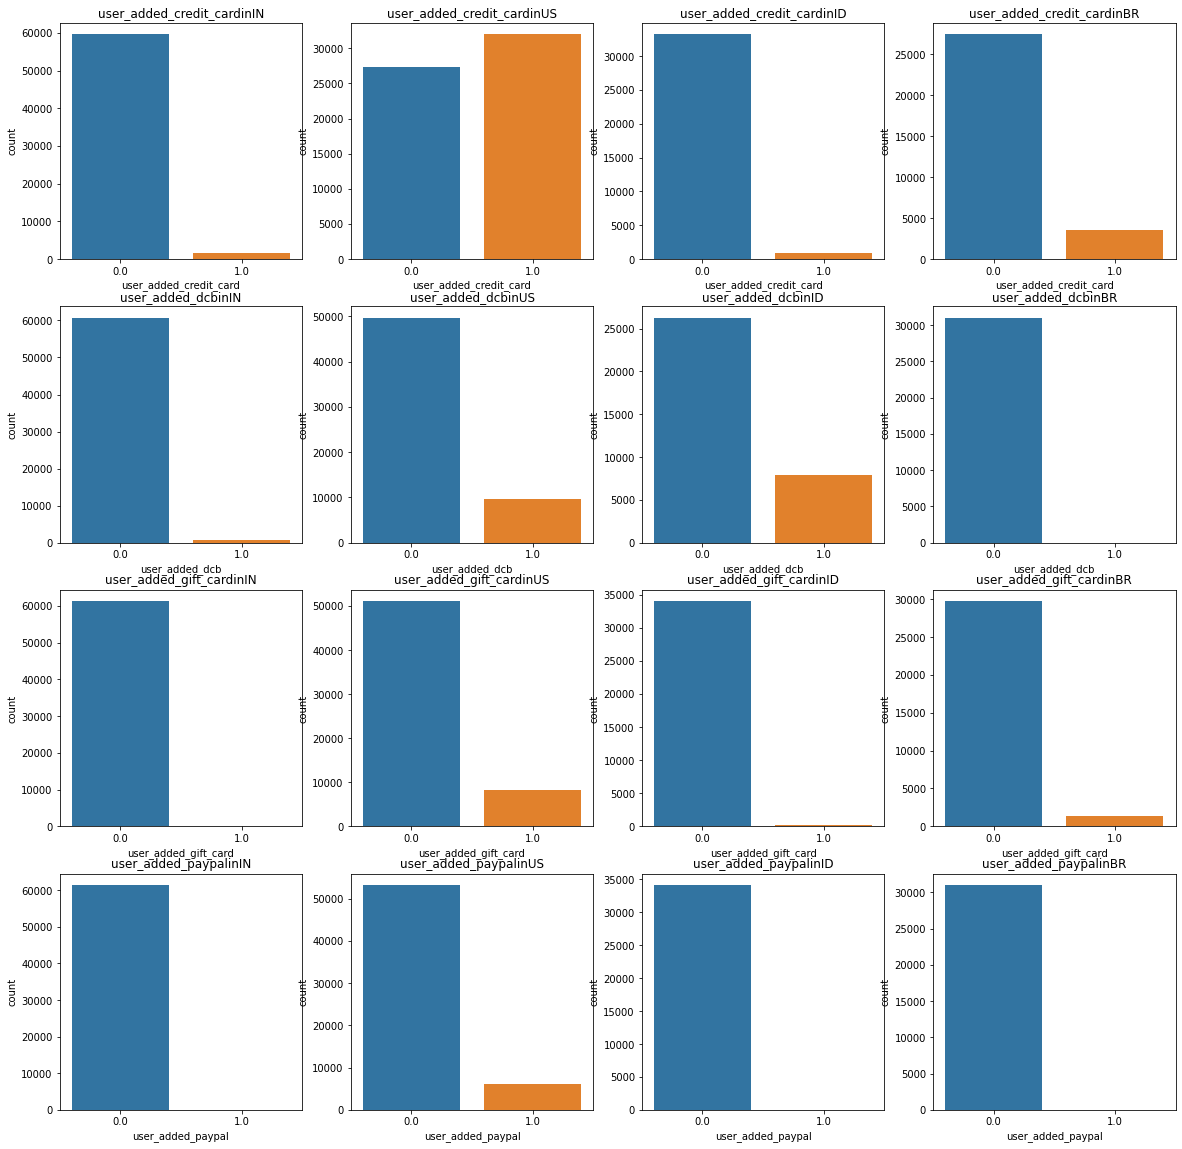

In [95]:
country = ["IN", "US", "ID", "BR"]
count = 1
fig = plt.figure(figsize = (20, 20))
for i, fop in enumerate(target_features):
  for j, c in enumerate(country):
    fig.add_subplot(4,4, count)
    sns.countplot(df[df["country"] == c][fop])
    plt.title(fop + "in" + c)
    count += 1

In [102]:
## Calculate the conversion rate of multiple payment method and single pyment method
def cr_fop(stage_interval, obj, df):
    tmp = df[df[obj] == 1][stage_interval].sum()
    return tmp[1] / tmp[0]

stage_interval = ["clicked_buy_before", "made_purchase_before"]


multiple_fop = []
for obj in target_features:
  cr = cr_fop(stage_interval, obj, df)
  multiple_fop.append(cr)

df["user_added_sum"] = df["user_added_credit_card"] + df["user_added_dcb"] + df["user_added_gift_card"] + df["user_added_paypal"]
single_fop_df = df[df["user_added_sum"] == 1]
single_fop = []
for obj in target_features:
  cr = cr_fop(stage_interval, obj, single_fop_df)
  single_fop.append(cr)


FOP conversion rate:
                      fop  multiple_fop  single_fop
0  user_added_credit_card      0.863623    0.809564
1          user_added_dcb      0.814635    0.711575
2    user_added_gift_card      0.960136    0.953946
3       user_added_paypal      0.883465    0.784256


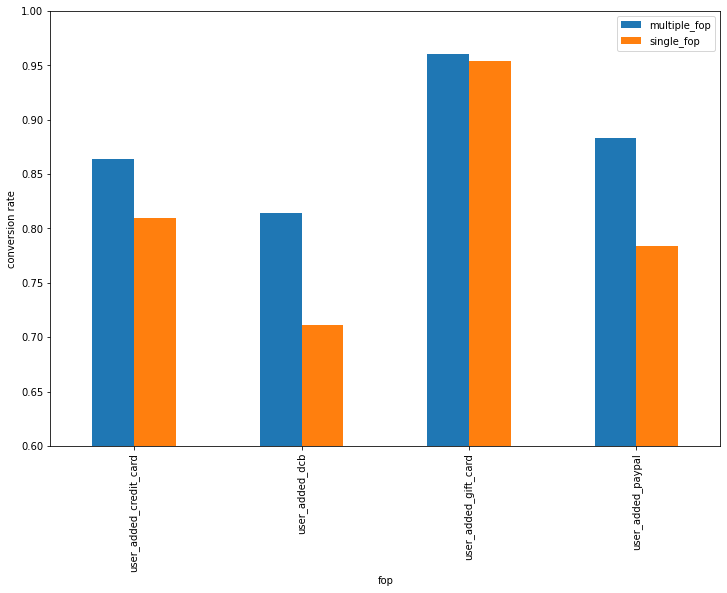

In [101]:
## Using var plot to visualize the conversion rate
res_fop_df = pd.DataFrame(columns=["fop", "multiple_fop", "single_fop"])
res_fop_df["fop"] = target_features
res_fop_df["multiple_fop"] = multiple_fop
res_fop_df["single_fop"] = single_fop
print ("FOP conversion rate:")
print (res_fop_df)

res_fop_df.plot.bar(x = "fop", y = ["multiple_fop", "single_fop"], figsize = (12, 8))
plt.ylim(0.6, 1.0)
plt.ylabel("conversion rate")
plt.show()

Combine the country result and payment result, my hypothesis is to try to encourage customers add credit card as payment method, if it is possible encourage them to add multiple payment methods